#Step 7
changed the optimizer - Replaced SGD with Adam optimization.

#Results:
*  Parameters: 6.1k
*  Best Train Accuracy: 99.31
*  Best Test Accuracy: 99.35

#Analysis
*  The accuracy improved but still short of target accuracy.
*  Now, we took a look at the test cases and found that the numbers are not always vertical but rotated. So, in next model we try to account for the cases which the model is not able to learn. We try to feed in data related to this cases more by data Augmentation. We rotate the data.

#Journey of the model

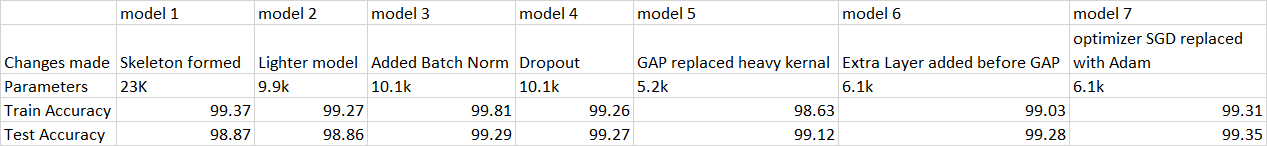

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/ML_assignment/ERA_V1/S7/ToSubmit/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML_assignment/ERA_V1/S7/ToSubmit


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import train_model, test_model
from utils import plot_data, plot_loss_accuracy

In [ ]:
# Device configuration -use CUDA tensor types if available
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
print("CUDA Available?", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

CUDA Available? False


In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    # transforms.RandomRotation((-7., 7.), fill=0),
    transforms.ToTensor(),   #convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)), #normalize test with  mean=0.1307 & standard deviation 0.3081
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) #apply the same normalization of train set to test set
    ])

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) #loads train-images-idx3-ubyte: training set images
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)  #loads t10k-images-idx3-ubyte

In [ ]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

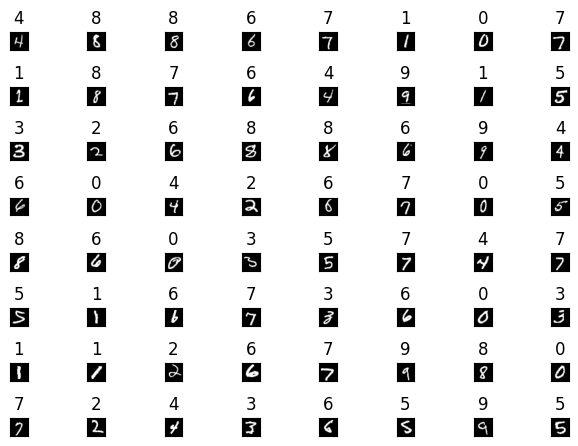

In [ ]:
import matplotlib.pyplot as plt
batch_data, batch_label = next(iter(train_loader))
# batch_data, batch_label = next(iter(test_loader))
plot_data(batch_data, batch_label, 64, 8, 8)

In [ ]:
#This class contains the architecture of the neural network
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    dropout = 0.1
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 8, 3, bias=False, padding=1), #Image Input: 28x28x1 -> 28x28x16  #Receptive Field 1 -> 3
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout(dropout),
        nn.Conv2d(8, 16, 3, bias=False), #Input: 28x28x16 -> 26x26x32  #Receptive Field 3 -> 5
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(dropout),
        #Transition Block = MaxPool + 1x1 Convolution
        #nn.Conv2d(16, 8, 1, bias=False),
        nn.MaxPool2d(2, 2),    #Input: 13x13x32 -> 13x13x32  #Receptive Field  5 -> 6
        nn.Conv2d(16, 8, 1, bias=False)   #Input: 13x13x32 -> 13x13x16  #Receptive Field  6 -> 6
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(8, 8, 3, bias=False),  #Input: 13x13x16 -> 11x11x16  #Receptive Field  6 -> 10
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout(dropout),
        nn.Conv2d(8, 8, 3, bias=False),  #Input: 11x11x16 -> 9x9x32  #Receptive Field  10 -> 14
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout(dropout)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(8, 16, 3, bias=False),  #Input: 9x9x32 -> 7x7x16  #Receptive Field  14 -> 18
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(dropout),
        nn.Conv2d(16, 10, 3, bias=False),  #Input: 7x7x16 -> 5x5x16  #Receptive Field  18 -> 22
        nn.ReLU(),
        nn.BatchNorm2d(10)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(10, 10,3, bias=False), #Input: 5x5x16 -> 1x1x10  #Receptive Field  26 -> 30
        nn.AdaptiveAvgPool2d((1, 1))
        )




  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(-1, 10)
    x = F.log_softmax(x, dim=1)
    return x

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 26, 26]           1,152
              ReLU-6           [-1, 16, 26, 26]               0
       BatchNorm2d-7           [-1, 16, 26, 26]              32
           Dropout-8           [-1, 16, 26, 26]               0
         MaxPool2d-9           [-1, 16, 13, 13]               0
           Conv2d-10            [-1, 8, 13, 13]             128
           Conv2d-11            [-1, 8, 11, 11]             576
             ReLU-12            [-1, 8, 11, 11]               0
    

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [ ]:
model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1, verbose=True)
#Negative log likelihood loss function is used to classify 10 classes [0-9 digits]
criterion = nn.NLLLoss()
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = train_model(model, device, train_loader, optimizer, criterion)
  train_accuracy.append(train_acc)
  train_losses.append(train_loss)
  test_acc, test_loss = test_model(model, device, test_loader, criterion)
  test_accuracy.append(test_acc)
  test_losses.append(test_loss)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0743 Batch_id=468 Accuracy=95.14: 100%|██████████| 469/469 [00:57<00:00,  8.13it/s]


Test set: Average loss: 0.0004, Accuracy: 9823/10000 (98.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0871 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:51<00:00,  9.12it/s]


Test set: Average loss: 0.0004, Accuracy: 9853/10000 (98.53%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0872 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:49<00:00,  9.53it/s]


Test set: Average loss: 0.0003, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0355 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:50<00:00,  9.35it/s]


Test set: Average loss: 0.0002, Accuracy: 9902/10000 (99.02%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0138 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:50<00:00,  9.31it/s]


Test set: Average loss: 0.0003, Accuracy: 9901/10000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0441 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:52<00:00,  8.91it/s]


Test set: Average loss: 0.0003, Accuracy: 9894/10000 (98.94%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.0152 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:50<00:00,  9.34it/s]


Test set: Average loss: 0.0002, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.0714 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:51<00:00,  9.12it/s]


Test set: Average loss: 0.0002, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.0508 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:49<00:00,  9.47it/s]


Test set: Average loss: 0.0002, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0117 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:49<00:00,  9.47it/s]


Test set: Average loss: 0.0002, Accuracy: 9931/10000 (99.31%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0190 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:51<00:00,  9.17it/s]


Test set: Average loss: 0.0002, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0056 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:50<00:00,  9.34it/s]


Test set: Average loss: 0.0002, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13


Train: Loss=0.0047 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:51<00:00,  9.18it/s]


Test set: Average loss: 0.0002, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 14


Train: Loss=0.0572 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:50<00:00,  9.22it/s]


Test set: Average loss: 0.0002, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15


Train: Loss=0.0020 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]


Test set: Average loss: 0.0002, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-04.


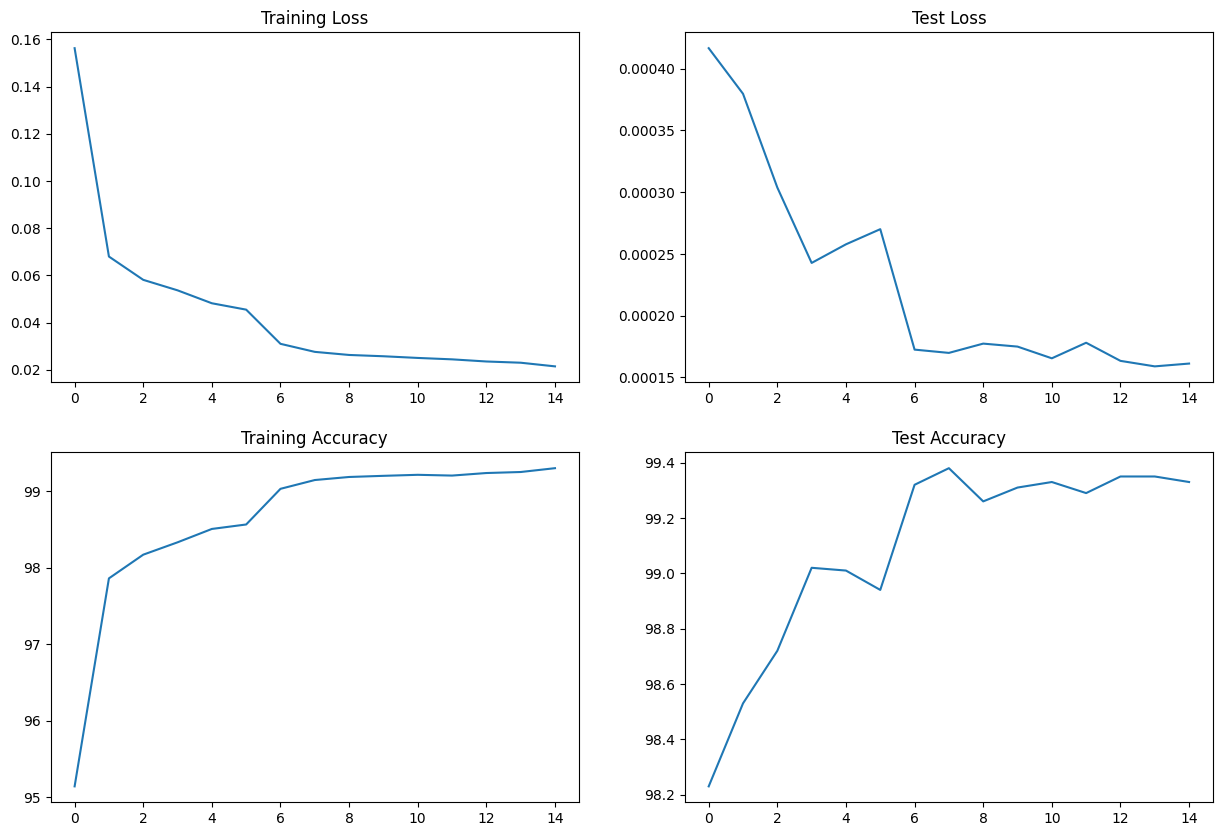

In [ ]:
plot_loss_accuracy(train_losses, test_losses, train_accuracy, test_accuracy)